In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans2
from dgp_aepmcm.gp_network import DGPNetwork
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score
np.random.seed(5)

In [2]:
def get_mnist_data(data_path='data'):
    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets(data_path+'/MNIST_data/', one_hot=False)

    X, Y = mnist.train.next_batch(mnist.train.num_examples)
    Xval, Yval = mnist.validation.next_batch(mnist.validation.num_examples)
    Xtest, Ytest = mnist.test.next_batch(mnist.test.num_examples)

    Y, Yval, Ytest = [np.array(y, dtype=float)[:, None] for y in [Y, Yval, Ytest]]

    X = np.concatenate([X, Xval], 0)
    Y = np.concatenate([Y, Yval], 0)
    
    return X.astype(np.float64), Y.astype(int), Xtest.astype(np.float64), Ytest.astype(int)

X_train, y_train, X_test, y_test = get_mnist_data()
print(X_train.shape)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
(60000, 784)


In [ ]:
"""
Use subset of data
"""
X_train = X_train[0:5000]
X_test = X_test[0:1000]
y_train = y_train[0:5000]
y_test = y_test[0:1000]

In [4]:
# DGP model variables
# Number of inducing points
M = 50
D = X_train.shape[-1]
# Maximun of epochs for training
max_epochs = 2
learning_rate = 0.01
minibatch_size = 70
n_samples_each_point = 10
n_samples = 20
# Inducing points locations
Z = kmeans2(X_train, M, minit="points")[0]
noise_val = 1e-5

In [5]:
# Instantiate and train DGP-AEPMCM. with L=3 and 3 GP nodes for the first two layers
model_aepmcm = DGPNetwork(
    X_train,
    y_train,
    inducing_points=Z,
    show_debug_info=True,
    jitter=1e-5,
    minibatch_size=minibatch_size)

model_aepmcm.add_input_layer()
# This method always assume a mean function for the prior p(u) = N(u| m(x), Kzz)
# with m(x) = X W
# For this example we disable the mean function for the prior so we set W to 0.
model_aepmcm.add_gp_layer(M, 3, W=np.zeros((D, 3))) # W=np.zeros((D, 3)))
model_aepmcm.add_noise_layer(noise_val)
model_aepmcm.add_gp_layer(M, 3, W=np.zeros((3, 3)))
model_aepmcm.add_noise_layer(noise_val)
model_aepmcm.add_gp_layer(M, 10, W=np.zeros((3, 10)))
model_aepmcm.add_noise_layer(noise_val)
model_aepmcm.add_output_layer_multiclass_classification()

model_aepmcm.train_via_adam(
    max_epochs=max_epochs,    
    learning_rate=learning_rate,
)

labels_aepmcm, probs_aepmcm = model_aepmcm.predict(X_test)

Creating DGP network for classification problem with 10 classes
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Compiling adam updates
Initializing network
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
Training for 2 epochs, 1716 iterations
Epoch: 0   | Energy: 0.925582    | Time: 262.5621s | Memory: 3.07 GB | ETA: -
Epoch: 1   | Energy: 0.579294    | Time: 274.1866s | Memory: 3.07

In [6]:
acc_dgp = accuracy_score(y_test, labels_aepmcm)
#recall_dgp = recall_score(y_test, labels_aepmcm)
print(f"Accuracy: {acc_dgp}")
#print(f"Recall: {recall_dgp}")

Accuracy: 0.8587


Label: [8], predicted: [8]


<IPython.core.display.Javascript object>


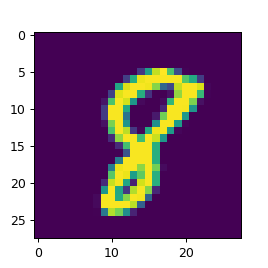

In [29]:
mnist_example_index = np.random.randint(0, X_test.shape[0])
print(f"Label: {y_test[mnist_example_index]}, predicted: {labels_aepmcm[mnist_example_index]}")
plt.figure(figsize=(3,3))
plt.imshow(X_test[mnist_example_index].reshape(int(D**0.5), int(D**0.5)))
plt.show()